# Pattern Recognition Final Project

#### Ahmed Mahmoud Fawzi                        ID:1170523
#### Amira Ahmed Adel                                 ID:1170400  
#### Mohammed Ahmed Abd El-Monem      ID:1170232

In [1]:
import os
import sys
import cv2 
import matplotlib.pyplot as plt
from os import listdir
import csv
from PIL import Image as PImage
from sklearn.cluster import KMeans
import numpy as np
from keras.layers import Activation
from keras import optimizers
import random
import tensorflow as tf
import matplotlib.pyplot as pyplot
import pandas as pd
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense,MaxPool2D,Flatten,Dropout
from tensorflow.keras.models import Sequential
from numpy import asarray
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow import keras
from keras.utils import np_utils
from keras.models import Sequential
from keras.regularizers import l2
import argparse
from keras.layers.convolutional import Convolution2D, MaxPooling2D ,Conv2D,ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Dense, Dropout, Activation, Flatten
from tensorflow.keras.optimizers import RMSprop
from keras.optimizers import Adam
from keras.optimizers import SGD
from sklearn.utils import shuffle
import os
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive




 # Functions Definition 




#### Load Paths

In [ ]:
# this function serves to load the paths for the .jpg images in the folder
def load_paths(Y_data):
    PatternPath ='/Users/modyf/Desktop/Pattern Final/DataSet/'
    filesJPG = []  # create an empty list
    for dirName, subdirList, fileList in os.walk(PatternPath):
        namedir=None
        for filename in fileList:
            Y_data.append(os.path.basename(os.path.normpath(dirName)))
            if ".jpg" in filename.lower():  
                namedir=[os.path.splitext(filename)[0],os.path.join(dirName,filename)]
                filesJPG.append(namedir)
    #return an array containing the paths
    return filesJPG

#### Read Iamges

In [ ]:
# this function reads all the images from the given array of paths it reads the images and sets  them in an array X_data
def Read(filenameDCM):
    
    # a temp loaded picture so that we could intialize the tyoe of the array we are creating and the size
    temp = cv2.imread(filenameDCM[0][1])
    temp = cv2.cvtColor(temp, cv2.COLOR_BGR2RGB)
    x=300
    y=300
    z=3
    ConstPixelDims = (x, y,z, len(filenameDCM))
    images=[]
    dim = (x, y)
    # itializing the X_Data array
    X_data = np.zeros(len(filenameDCM)*x*y*z,dtype=temp.dtype)
    print(temp.dtype)
    # reshaping the X_data array to be (totalpicsize,300,300,3)
    X_data=np.reshape(X_data,(len(filenameDCM),x,y,z))
    # a temp array created to load pics
    new_array = np.zeros(ConstPixelDims, dtype=temp.dtype)
    # Loop across all the paths and then read the imamges
    for i in range(len(filenameDCM)):
        # Read the Image
        img = cv2.imread(filenameDCM[i][1])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # Resize all immages to a fixed size 300*300
        img=cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
        new_array[:, :,:, i] = img
        X_data[i] = new_array[:,:,:,i]
    # return the X_Data array
    return X_data 

#### Augment Images Function

In [ ]:
# This function serves to make Audmentation for the Images to increase the dataset
def AugmentImages_Save(X_data):
    # an array with the current size of data iamges
    arr=[128,98,91,107,99,100,88,114,200,86,239]
    c=0
    k=0
    c=arr[k]
    ind=c
    os.mkdir(str(ind))
    check=0
    # loop accross the all the images in X_data array we created
    for j,data in enumerate(X_data):
        #  if we reached the same number as the current size of images in the arr ( this means we have looped accross all images of category 1 for exampel)
        if check==arr[k]:
            k+=1
            # reupdate the c so that we could rename images automaticaly
            c=arr[k]
            ind=c
            # create a directory for the new category images
            os.mkdir(str(ind))
            check=0        
        # for this part we create an image with different brightness from the passed image
        samples = expand_dims(data, 0)
        datagen = ImageDataGenerator(brightness_range=[0.6,1.5])
        it = datagen.flow(samples, batch_size=2)
        for i in range(1):

            batch = it.next()
            image = batch[0].astype('uint8')
            # save the new image
            c=c+1
            num="%04d" % (c)
            cv2.imwrite(str(ind)+"/image_"+num.strip()+".jpg", image)
            
        # for this part we create a new rotated image different from the passed image
        datagen = ImageDataGenerator(rotation_range=45)
        it = datagen.flow(samples, batch_size=1)
        for i in range(1):

            batch = it.next()
            image = batch[0].astype('uint8')
            # save the new image
            c=c+1
            num="%04d" % (c)
            cv2.imwrite(str(ind)+"/image_"+num.strip()+".jpg", image)

        # for this part we create a new flipped image different from the passed image
        datagen = ImageDataGenerator(horizontal_flip=True)
        it = datagen.flow(samples, batch_size=1)
        for i in range(1):
            batch = it.next()
            image = batch[0].astype('uint8')
            # save the new image
            c=c+1
            num="%04d" % (c)
            cv2.imwrite(str(ind)+"/image_"+num.strip()+".jpg", image)
        check+=1 

#### Normalize Function

In [ ]:
# Normalize the Data Function we normalize the data to be in range 0-1 as the min x is 0 and the max is 255 so we divide all elements
# by 255 making the range 0-1
def NormalizeData(X):
    print("X min Before:", np.min(X))
    print("X max Before:", np.max(X))
    X = X.astype('float32')
    X /= 255
    print("X min After:", np.min(X))
    print("X max After:", np.max(X))
    return X

#### Transform Labels Function

In [18]:
# this function serves to transform the class labels to 0,1,3,4,5,6,7,8,9,10
def TransformLabels(Y_data):
    for i in range(len(Y_data)):
        if Y_data[i]=="bonsai":
            Y_data[i]=0
        elif Y_data[i]=="brain":
            Y_data[i]=1
        elif Y_data[i]=="butterfly":
            Y_data[i]=2
        elif Y_data[i]=="chandelier":
            Y_data[i]=3
        elif Y_data[i]=="grand_piano":
            Y_data[i]=4
        elif Y_data[i]=="hawksbill":
            Y_data[i]=5
        elif Y_data[i]=="helicopter":
            Y_data[i]=6
        elif Y_data[i]=="ketch":
            Y_data[i]=7
        elif Y_data[i]=="Leopards":
            Y_data[i]=8
        elif Y_data[i]=="starfish":
            Y_data[i]=9
        elif Y_data[i]=="watch":
            Y_data[i]=10

#### Shuffle Fucntion

In [ ]:
# This functions serves to shuffle your data if needed as the computational cost is high if every time a new split for the X_data is done
# so if we have all the X_train,Y_train,X_test,Y_test,X_val,Y_val data saved already we just load them and call this fucntion 
def Reshuffle(X_train,Y_train,X_test,Y_test,X_val,Y_val):
    # Shuffle the data and then returning them 
    X_train,Y_train = shuffle(X_train, Y_train)
    X_test,Y_test = shuffle(X_test, Y_test)
    X_val,Y_val = shuffle(X_val, Y_val)
    return X_train,Y_train,X_test,Y_test,X_val,Y_val

#### Graph Diagnostics Function

In [76]:
# This Function save 2 graphs for Cross Entropy Loss and for Classification Accuracy
def Graph_diagnostics(history):
    # Cross Entropy Loss
    pyplot.subplot(311)
    pyplot.title('Cross Entropy Loss')
    pyplot.plot(history.history['loss'], color='blue', label='train')
    pyplot.plot(history.history['val_loss'], color='orange', label='test')
    filename = sys.argv[0].split('/')[-1]
    pyplot.savefig(filename +"1" '_plot.png')
    #Classification Accuracy
    pyplot.subplot(313)
    pyplot.title('Classification Accuracy')
    pyplot.plot(history.history['accuracy'], color='blue', label='train')
    pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
    # save plot to file
    filename = sys.argv[0].split('/')[-1]
    pyplot.savefig(filename +"2" '_plot.png')


#### Show and Predict Function

In [45]:
# This function serves to predict the passed X_test image and then shows and print the prediction
def Show_and_Predict(X_test):
    labels_dic = {
            0: "Bonsai",
            1: "Brain",
            2: "Butterfly",
            3: "Chandelier",
            4: "Grand Piano",
            5: "Hawks Bill",
            6: "Helicopter",
            7: "Ketch",
            8: "Leaopards",
            9: "Starfish",
            10: "Watch",
        }
    X_pred=np.reshape(X_test,(1, X_test.shape[0], X_test.shape[1], 3))
    ypred=model.predict(X_pred)
    y_pred=np.argmax(ypred, axis = 1)
    plt.imshow(X_test)
    print(labels_dic[int(y_pred)])

#### Print Statistics Function

In [22]:
# This Function Prints the Statitics of the model
def Statistics(Y_test_,y_pred):
    labels_dic = {
            0: "Bonsai",
            1: "Brain",
            2: "Butterfly",
            3: "Chandelier",
            4: "Grand Piano",
            5: "Hawks Bill",
            6: "Helicopter",
            7: "Ketch",
            8: "Leaopards",
            9: "Starfish",
            10: "Watch",
        }
    ## Print the Accuracy Score 
    print("Classification Accuracy Score: ", accuracy_score(Y_test_, y_pred))
    print("---")
    ## Print the Recall of the classes 
    recall_of_classes = (recall_score(Y_test_, y_pred, average=None))
    for index, recall in enumerate(recall_of_classes):
        print("Recall of {}:".format(labels_dic[index]), recall)


    print("---")
    ## Print the Precision of the classes 
    precision_of_classes = (precision_score(Y_test_, y_pred, average=None))
    for index, perc in enumerate(precision_of_classes):
        print("Precison of {}:".format(labels_dic[index]), perc)

    print("---")
    ## Print the F1 of the classes 
    f1_of_classes = (f1_score(Y_test_, y_pred, average=None))
    for index, f1 in enumerate(f1_of_classes):
        print("F1 of {}:".format(labels_dic[index]), f1)
    print("---")
    ## Print the Mean Squared Error 
    mse=mean_squared_error(Y_test_, y_pred)
    print("Mean_Squared_Error:", mse)
    
    print("---")
    
    ## Print the Mean Absolute Error 
    mae=mean_absolute_error(Y_test_, y_pred)
    print("Mean_Absolute_Error: ", mae)
    
    print("---")
    
    
    # Get the confusion matrix
    cm = confusion_matrix(Y_test_, y_pred)

    # We will store the results in a dictionary for easy access later
    per_class_accuracies = {}

    # Calculate the accuracy for each one of our classes
    for idx, cls in enumerate([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]):
        # True negatives are all the samples that are not our current GT class (not the current row) 
        # and were not predicted as the current class (not the current column)
        true_negatives = np.sum(np.delete(np.delete(cm, idx, axis=0), idx, axis=1))

        # True positives are all the samples of our current GT class that were predicted as such
        true_positives = cm[idx, idx]

        # The accuracy for the current class is ratio between correct predictions to all predictions
        per_class_accuracies[cls] = (true_positives + true_negatives) / np.sum(cm)
    key_list = ["Bonsai", "Brain", "Butterfly", "Chandelier", "Grand Piano", "Hawks Bill", "Helicopter", "Ketch", "Leaopards", "Starfish", "Watch"]
    val_list = list(per_class_accuracies.values())
    dictionary = dict(zip(key_list, val_list))
    for index, accuracy in enumerate(val_list):
        print("Accuracy of {}:".format(key_list[index]), accuracy)
            
    print("---")



***

# Pre-Processing Data

***

#### Load , Read Images , and Save X_Data array to save time later 

In [ ]:
Y_data=[]
filesJPG=load_paths(Y_data)
TransformLabels(Y_data)
Y_data=np.asarray(Y_data)
X_data=Read(filesJPG)
AugmentImages_Save(X_data)
filesJPG=load_paths()
X_data=Read(filesJPG)
np.save('X_data',X_data,allow_pickle=False,fix_imports=False)
np.save('Y_data',Y_data,allow_pickle=False,fix_imports=False)
X_data=[]
Y_data=[]

#### Load X_data and Y_data from the saved .npy files

In [ ]:
X_data = np.load('X_data.npy', mmap_mode='r')
Y = np.load('Y_data.npy', mmap_mode='r')
Y=Y.reshape(-1,1)

#### Normalizing the X_data

In [ ]:
X=NormalizeData(X_data)

#### Splitting the X_data and Y_data into X_train,Y_train,X_test,Y_test,X_val,Y_val

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30,shuffle=True)
X_test, X_val, Y_test,Y_val = train_test_split(X_test, Y_test, test_size=0.50,shuffle=True) 

#### Making One-Hot encoding for the Labels

In [ ]:
Y_train = np_utils.to_categorical(Y_train)
Y_test = np_utils.to_categorical(Y_test)
Y_val= np_utils.to_categorical(Y_val)

#### Saving all the data created as .npy files to later process faster and save computational power

In [ ]:
np.save('X_train',X_train,allow_pickle=False,fix_imports=False) 
np.save('X_test',X_test,allow_pickle=False,fix_imports=False) 
np.save('Y_train',Y_train,allow_pickle=False,fix_imports=False) 
np.save('Y_test',Y_test,allow_pickle=False,fix_imports=False) 
np.save('X_val',X_val,allow_pickle=False,fix_imports=False) 
np.save('Y_val',Y_val,allow_pickle=False,fix_imports=False) 

# Code May Now Start From Here Directly

#### Loading the saved .npy files

In [3]:
X_train = np.load('/content/drive/MyDrive/Best Model 2/X_train.npy', mmap_mode='r')
X_test = np.load('/content/drive/MyDrive/Best Model 2/X_test.npy', mmap_mode='r')
X_val = np.load('/content/drive/MyDrive/Best Model 2/X_val.npy', mmap_mode='r')
Y_test = np.load('/content/drive/MyDrive/Best Model 2/Y_test.npy', mmap_mode='r')
Y_train = np.load('/content/drive/MyDrive/Best Model 2/Y_train.npy', mmap_mode='r')
Y_val = np.load('/content/drive/MyDrive/Best Model 2/Y_val.npy', mmap_mode='r')

#### Reshuffle the data if needed

In [ ]:
X_train,Y_train,X_test,Y_test,X_val,Y_val=Reshuffle(X_train,Y_train,X_test,Y_test,X_val,Y_val)

***

# CNN Model Create

***

In [6]:
model = Sequential()

# 1st conv block
model.add(Conv2D(128,  (3, 3), padding ="same", input_shape=(300, 300, 3)))
model.add(MaxPool2D(pool_size=(2, 2), padding='same'))
# 2nd conv block
model.add(Conv2D(256, (3, 3), activation='relu', strides=(2, 2), padding='same'))
model.add(MaxPool2D(pool_size=(2, 2), padding='same'))
# 3rd conv block
model.add(Conv2D(512, (3, 3), activation='relu', strides=(2, 2), padding='same'))
model.add(MaxPool2D(pool_size=(2, 2), padding='valid'))

model.add(Dropout(0.2))


# ANN block
model.add(Flatten())
model.add(Dense(512))
model.add(Activation("relu"))
model.add(Dropout(0.2))

# Output Layer
model.add(Dense(11, activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer=optimizers.Adam(learning_rate=0.001),metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 300, 300, 128)     3584      
_________________________________________________________________
module_wrapper_3 (ModuleWrap (None, 150, 150, 128)     0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 75, 75, 256)       295168    
_________________________________________________________________
module_wrapper_4 (ModuleWrap (None, 38, 38, 256)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 19, 19, 512)       1180160   
_________________________________________________________________
module_wrapper_5 (ModuleWrap (None, 9, 9, 512)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 9, 9, 512)        

In [7]:
# Fit the model
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=2, min_lr=0.0001)
hist = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=20, batch_size=50,callbacks=reduce_lr)
# Final evaluation of the model
scores = model.evaluate(X_test, Y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Epoch 1/20
61/61 [==============================] - 89s 1s/step - loss: 2.3968 - accuracy: 0.2760 - val_loss: 0.9223 - val_accuracy: 0.7066
Epoch 2/20
61/61 [==============================] - 58s 948ms/step - loss: 0.8196 - accuracy: 0.7403 - val_loss: 0.6512 - val_accuracy: 0.7834
Epoch 3/20
61/61 [==============================] - 58s 949ms/step - loss: 0.4618 - accuracy: 0.8552 - val_loss: 0.4615 - val_accuracy: 0.8464
Epoch 4/20
61/61 [==============================] - 58s 947ms/step - loss: 0.2181 - accuracy: 0.9252 - val_loss: 0.4375 - val_accuracy: 0.8710
Epoch 5/20
61/61 [==============================] - 58s 949ms/step - loss: 0.1721 - accuracy: 0.9358 - val_loss: 0.3468 - val_accuracy: 0.9017
Epoch 6/20
61/61 [==============================] - 58s 947ms/step - loss: 0.0944 - accuracy: 0.9674 - val_loss: 0.4468 - val_accuracy: 0.8955
Epoch 7/20
61/61 [==============================] - 58s 946ms/step - loss: 0.1181 - accuracy: 0.9629 - val_loss: 0.4343 - val_accuracy: 0.8725
Ep

##### Save 2 graphs for Cross Entropy Loss and for Classification Accuracy

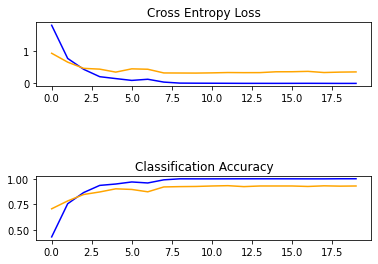

In [15]:
Graph_diagnostics(hist)

#### Predict and show Image

Brain


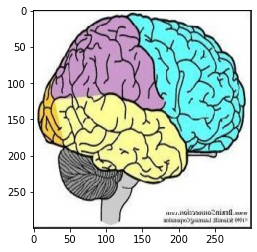

In [58]:
Analyse_and_Predict(X_test[60])

#### Print Statistics ( Accuracy,Precision,Recall,F1,MSE,MAE)

In [23]:
y_pred=model.predict(X_test)
Y_test_ = np.argmax(Y_test, axis = 1)
y_pred=np.argmax(y_pred, axis = 1)
Statistics(Y_test_,y_pred)

Classification Accuracy Score:  0.9461538461538461
---
Recall of Bonsai: 0.9571428571428572
Recall of Brain: 0.9666666666666667
Recall of Butterfly: 0.9318181818181818
Recall of Chandelier: 0.9696969696969697
Recall of Grand Piano: 0.9803921568627451
Recall of Hawks Bill: 0.9272727272727272
Recall of Helicopter: 0.88
Recall of Ketch: 0.987012987012987
Recall of Leaopards: 1.0
Recall of Starfish: 0.9310344827586207
Recall of Watch: 0.847457627118644
---
Precison of Bonsai: 0.9571428571428572
Precison of Brain: 0.9206349206349206
Precison of Butterfly: 0.8913043478260869
Precison of Chandelier: 0.8888888888888888
Precison of Grand Piano: 1.0
Precison of Hawks Bill: 0.9444444444444444
Precison of Helicopter: 0.9361702127659575
Precison of Ketch: 0.9743589743589743
Precison of Leaopards: 0.967741935483871
Precison of Starfish: 0.9473684210526315
Precison of Watch: 0.9803921568627451
---
F1 of Bonsai: 0.9571428571428572
F1 of Brain: 0.943089430894309
F1 of Butterfly: 0.9111111111111111
F1 o

# AlexnetModel

In [73]:
def AlexnetModel(input_shape,num_classes):
    
    model = Sequential()
    model.add(Conv2D(filters=96,kernel_size=(3,3),strides=(4,4),input_shape=input_shape, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(256,(5,5),padding='same',activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(384,(3,3),padding='same',activation='relu'))
    model.add(Conv2D(384,(3,3),padding='same',activation='relu'))
    model.add(Conv2D(256,(3,3),padding='same',activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(num_classes,activation='softmax'))
    
    return model

In [ ]:
AlexModel = AlexnetModel((300,300,3),11)
optimizer = SGD(lr=0.001)
AlexModel.compile(loss= 'categorical_crossentropy' , optimizer=optimizer, metrics=[ 'accuracy' ])
print("Model Summary of ","Alex")
print(AlexModel.summary())
# Fit the model
hist = AlexModel.fit(X_train, Y_train, validation_data=(X_val, Y_val),validation_freq=1 ,epochs=50, batch_size=32)
# Final evaluation of the model
scores = AlexModel.evaluate(X_test, Y_test)
print("Accuracy: %.2f%%" % (scores[1]*100))

In [83]:
y_pred=AlexModel.predict(X_test)
Y_test_ = np.argmax(Y_test, axis = 1)
y_pred=np.argmax(y_pred, axis = 1)
Statistics(Y_test_,y_pred)

Classification Accuracy Score:  0.9707692307692307
---
Recall of Bonsai: 0.9714285714285714
Recall of Brain: 1.0
Recall of Butterfly: 0.9318181818181818
Recall of Chandelier: 0.9393939393939394
Recall of Grand Piano: 1.0
Recall of Hawks Bill: 0.9272727272727272
Recall of Helicopter: 0.96
Recall of Ketch: 0.974025974025974
Recall of Leaopards: 1.0
Recall of Starfish: 1.0
Recall of Watch: 0.9661016949152542
---
Precison of Bonsai: 0.9577464788732394
Precison of Brain: 0.967741935483871
Precison of Butterfly: 0.9761904761904762
Precison of Chandelier: 0.96875
Precison of Grand Piano: 1.0
Precison of Hawks Bill: 0.9444444444444444
Precison of Helicopter: 0.9795918367346939
Precison of Ketch: 1.0
Precison of Leaopards: 0.9836065573770492
Precison of Starfish: 0.9508196721311475
Precison of Watch: 0.95
---
F1 of Bonsai: 0.9645390070921985
F1 of Brain: 0.9836065573770492
F1 of Butterfly: 0.9534883720930233
F1 of Chandelier: 0.9538461538461539
F1 of Grand Piano: 1.0
F1 of Hawks Bill: 0.9357798

#### Save The Models

In [ ]:
model.save('Model')
AlexModel.save('AlexNet_Model')